# STATS507 Problem Set 4

*Yurui Chang*

In [2]:
import pandas as pd
import numpy as np
import os
import math
import matplotlib.pyplot as plt
from scipy import stats
from itertools import product

## Question 0 - Topics in Pandas

## Pandas.to_timedelta

- To convert a recognized timedelta format / value into a Timedelta type
- the unit of the arg
  * 'W'
  * 'D'/'days'/'day'
  * ‘hours’ / ‘hour’ / ‘hr’ / ‘h’
  * ‘m’ / ‘minute’ / ‘min’ / ‘minutes’ / ‘T’
  * ‘S’ / ‘seconds’ / ‘sec’ / ‘second’
  * ‘ms’ / ‘milliseconds’ / ‘millisecond’ / ‘milli’ / ‘millis’ / ‘L’
  * ‘us’ / ‘microseconds’ / ‘microsecond’ / ‘micro’ / ‘micros’ / ‘U’
  * ‘ns’ / ‘nanoseconds’ / ‘nano’ / ‘nanos’ / ‘nanosecond’ / ‘N’

* Parsing a single string to a Timedelta
* Parsing a list or array of strings
* Converting numbers by specifying the unit keyword argument

In [32]:
time1 = pd.to_timedelta('1 days 06:05:01.00003')
time2 = pd.to_timedelta('15.5s')
print([time1, time2])
pd.to_timedelta(['1 days 06:05:01.00003', '15.5s', 'nan'])

[Timedelta('1 days 06:05:01.000030'), Timedelta('0 days 00:00:15.500000')]


TimedeltaIndex(['1 days 06:05:01.000030', '0 days 00:00:15.500000', NaT], dtype='timedelta64[ns]', freq=None)

In [33]:
pd.to_timedelta(np.arange(5), unit='d')

TimedeltaIndex(['0 days', '1 days', '2 days', '3 days', '4 days'], dtype='timedelta64[ns]', freq=None)

## pandas.to_datetime

* To convert argument to datetime
* Returns: datetime, return type dependending on input
  * list-like: DatetimeIndex
  * Series: Series of datetime64 dtype
  * scalar: Timestamp
* Assembling a datetime from multiple columns of a DataFrame
* Converting Pandas Series to datetime w/ custom format
* Converting Unix integer (days) to datetime
* Convert integer (seconds) to datetime

In [34]:
s = pd.Series(['date is 01199002',
           'date is 02199015',
           'date is 03199020',
           'date is 09199204'])
pd.to_datetime(s, format="date is %m%Y%d")

0   1990-01-02
1   1990-02-15
2   1990-03-20
3   1992-09-04
dtype: datetime64[ns]

In [35]:
time1 = pd.to_datetime(14554, unit='D', origin='unix')
print(time1)
time2 = pd.to_datetime(1600355888, unit='s', origin='unix')
print(time2)

2009-11-06 00:00:00
2020-09-17 15:18:08


## Question 1 - NHANES Table 1 
### part a)

In [2]:
index_list1 = ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH3', 'DMDEDUC2', 'DMDMARTL',
              'RIDSTATR', 'SDMVPSU', 'SDMVSTRA', 'WTMEC2YR', 'WTINT2YR']

# read files and and a column
path1 = r"./demographic"
files1 = os.listdir(path1)
dat1 = []
for file in files1:
    if file.endswith('.XPT'):
        a = pd.read_sas(path1+'/'+file)
        # select specified columns
        a = a[index_list1]
        # add the column identifying to which cohort each case belongs
        a['YEAR'] = [file[6:10] for i in range(len(a))]
        dat1.append(a)
        
df1 = pd.concat(dat1, ignore_index=True)

# rename columns
df1 = df1.rename(columns = {'SEQN': 'id', 'RIAGENDR': 'gender', 'RIDAGEYR':'age', 
                            'RIDRETH3':'race', 'DMDEDUC2':'education', 
                            'DMDMARTL':'marital_status', 'SDMVPSU':'psu', 
                            'SDMVSTRA':'stratum'})
df1.columns = df1.columns.str.lower()

# object: id
# int: age, psu, stratum
# category: gender, race, education, marital_status, ridstatr
df1['id'] = df1['id'].astype(int).astype(object)

l1_1 = ['age', 'psu', 'stratum']
df1[l1_1] = df1[l1_1].astype(int)

l1_2 = ['gender', 'race', 'education', 'marital_status', 'ridstatr']
df1[l1_2] = df1[l1_2].fillna(-1).astype('Int8')
for k in l1_2:
    df1[k] = pd.Categorical(df1[k])

In [3]:
# columns
dat = pd.read_sas('./ohxden/OHXDEN_G2011.XPT')
index_list2 = ['SEQN','OHDDESTS']
all_index = dat.columns
for a in all_index:
    if a[:3] == 'OHX' and a[-2:] == 'TC':
        index_list2.append(a)

path2 = r"./ohxden"
files2 = os.listdir(path2)
dat2 = []
for file in files2:
    if file.endswith('.XPT'):
        a = pd.read_sas(path2+'/'+file)
        # select specified columns
        index_list2 = ['SEQN','OHDDESTS']
        all_index = dat.columns
        for idx in all_index:
            if idx[:3] == 'OHX' and idx[-2:] == 'TC':
                index_list2.append(idx)
        a = a[index_list2]
        # add the column identifying to which cohort each case belongs
        a['YEAR'] = [file[-8:-4] for i in range(len(a))]
        dat2.append(a)
        
df2 = pd.concat(dat2, ignore_index=True)

# rename columns
df2 = df2.rename(columns = {'SEQN': 'id'})
df2.columns = df2.columns.str.lower()

# object: id
# category: ohddests, ohxXXtc, ohxXXctc
columnNames2 = df2.columns

## seqn
df2['id'] = df2['id'].astype(int).astype(object)

## ohxXXctc
l2_1 = [x for x in columnNames2 if x[-3:] == 'ctc']
for idx in l2_1:
    df2[idx] = df2[idx].str.decode('utf8', errors='strict').astype('category')

## ohxXXtc & ohddests
l2_2 = [x for x in columnNames2 if x[-2:]=='tc' and x[-3]!='c']
l2_2.append('ohddests')
df2[l2_2] = df2[l2_2].fillna(-1).astype(int)
for x in l2_2:
    df2[x] = pd.Categorical(df2[x])

In [4]:
# save to pickle
df1.to_pickle('./demographic.pkl')
df2.to_pickle('./ohxden.pkl')

In [5]:
# load dataset
df1 = pd.read_pickle(r'./demographic.pkl')
df2 = pd.read_pickle(r'./ohxden.pkl')

### part b)

In [6]:
# merge two tables
demo = df1.merge(df2[['id', 'year', 'ohddests']], on=['year', 'id'], how='left')
demo.rename(columns={'ridstatr': 'exam_status', 'ohddests': 'ohx_status'}, inplace=True)

# add a new column 'under_20'
demo['under_20'] = 'no'
demo.loc[demo['age'] < 20, 'under_20'] = 'yes'

# add a new column 'college'
conditions = [
    (demo['education'] == 4) | (demo['education'] == 5),
    (demo['education'] != 4) & (demo['education'] != 5),
    (demo['age'] < 20)
]
values = ['some college/college graduate', 'No college/<20', 'No college/<20']
demo['college'] = np.select(conditions, values)

# create a new dataframe
demo_new = demo[['id', 'gender', 'age', 'under_20', 'college', 'exam_status', 
                 'ohx_status']]

# create a new variable called 'ohx'
demo_new['ohx'] = 'missing'
demo_new.loc[(demo_new['exam_status'] == 2) & (demo_new['ohx_status'] == 1), 'ohx'] = 'complete'
demo_new[['under_20', 'college', 'ohx']] = demo_new[['under_20', 'college', 'ohx']].astype('category')

demo_new

<ipython-input-6-35730c9538f6>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_new['ohx'] = 'missing'
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,id,gender,age,under_20,college,exam_status,ohx_status,ohx
0,83732,1,62,no,some college/college graduate,2,1,complete
1,83733,1,53,no,No college/<20,2,1,complete
2,83734,1,78,no,No college/<20,2,1,complete
3,83735,2,56,no,some college/college graduate,2,1,complete
4,83736,2,42,no,some college/college graduate,2,1,complete
...,...,...,...,...,...,...,...,...
39151,83727,1,26,no,some college/college graduate,2,1,complete
39152,83728,2,2,yes,No college/<20,2,1,complete
39153,83729,2,42,no,some college/college graduate,2,1,complete
39154,83730,1,7,yes,No college/<20,2,1,complete


### part c)

In [7]:
demo_new.drop(demo_new[demo_new['exam_status'] != 2].index, inplace=True)
demo_new

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,id,gender,age,under_20,college,exam_status,ohx_status,ohx
0,83732,1,62,no,some college/college graduate,2,1,complete
1,83733,1,53,no,No college/<20,2,1,complete
2,83734,1,78,no,No college/<20,2,1,complete
3,83735,2,56,no,some college/college graduate,2,1,complete
4,83736,2,42,no,some college/college graduate,2,1,complete
...,...,...,...,...,...,...,...,...
39151,83727,1,26,no,some college/college graduate,2,1,complete
39152,83728,2,2,yes,No college/<20,2,1,complete
39153,83729,2,42,no,some college/college graduate,2,1,complete
39154,83730,1,7,yes,No college/<20,2,1,complete


There are 1757 rows removed from the table, and 37399 subjects remaining.

### part d)

In [19]:
def count_summ(varname):
    """
    Count the number of each variable

    Parameters
    ----------
    varname : string
        The variable name.
        
    Returns
    -------
    The table of the results.

    """
    summ_tbl = (demo_new
        .groupby([varname, 'ohx'])
        .apply(lambda x: len(x))
        )
    summ_tbl.index.names = ['category', 'ohx']
    summ_tbl = summ_tbl.reset_index().pivot(index='category', columns='ohx')
    summ_tbl.columns = ['complete', 'missing']
    p = stats.chi2_contingency(np.array(summ_tbl))[1]
    summ_tbl['p-value'] = ""
    summ_tbl.iloc[0, 2] = ("%.3g" % p)
    string = "n = {0:d} ({1:4.2f}%)"
    for i in range(2):
        t = sum(summ_tbl.iloc[i,0:2])
        for j in range(2):
            summ_tbl.iloc[i,j] = string.format(int(summ_tbl.iloc[i,j]), 
                                               100*summ_tbl.iloc[i,j]/t)
    return summ_tbl

In [21]:
# count the number of `under_20`, `gender`, and `college`
under20_tbl = count_summ('under_20')
gender_tbl = count_summ('gender')
college_tbl = count_summ('college')
tbl_all = pd.concat([under20_tbl, gender_tbl, college_tbl])

# count the number of `age`
age_tbl = (demo_new
           .groupby('ohx')
           .apply(lambda x: pd.Series({'mean': np.mean(x.age),
                                       'sd': np.std(x.age)})))
tbl_all.loc['age_mean',:] = ''
tbl_all.iloc[6,0] = 'mean = {0:4.2f} (sd = {1:4.2f})'.format(age_tbl.iloc[0,0], 
                                                             age_tbl.iloc[0,1])
tbl_all.iloc[6,1] = 'mean = {0:4.2f} (sd = {1:4.2f})'.format(age_tbl.iloc[1,0], 
                                                             age_tbl.iloc[1,1])
p =  stats.ttest_ind(demo_new.loc[demo_new['ohx']=='complete', 'age'],
                      demo_new.loc[demo_new['ohx']!='complete', 'age']).pvalue
tbl_all.iloc[6,2] = ("%.3g" % p)

# polish the table
a1 = np.append(np.repeat(['under_20', 'gender', 'college'],2), ['age'])
a2 = ['no', 'yes', 'male', 'female', 'no college/<20', 'some college/college graduate',
      'age_mean']
tbl_all.index = pd.MultiIndex.from_arrays([a1, a2], names=['index', 'category'])
tbl_all

complete  \
index    category                                                   
under_20 no                                    n = 20369 (94.10%)   
         yes                                   n = 13991 (88.81%)   
gender   male                                  n = 17018 (92.33%)   
         female                                n = 17342 (91.43%)   
college  no college/<20                        n = 22974 (90.45%)   
         some college/college graduate         n = 11386 (94.90%)   
age      age_mean                       mean = 33.17 (sd = 24.37)   

                                                          missing    p-value  
index    category                                                             
under_20 no                                      n = 1277 (5.90%)   4.96e-76  
         yes                                    n = 1762 (11.19%)             
gender   male                                    n = 1413 (7.67%)    0.00144  
         female                                  n = 1626 (8.57%)             
college  no college/<20                          n = 2427 (9.55%)   6.98e-49  
         some college/college graduate            n = 612 (5.10%)             
age      age_mean                       mean = 22.01 (sd = 26.58)  1.77e-126

## Question 2 - Monte Carlo Comparison
### part a) Level Calibration

In [23]:
def bino_ci(dat, method, level, form_string):
    """
    Calculating the point and interval estiamte based different methods

    Parameters
    ----------
    dat : float
        data.
    method : str
        The method used.
    level : float
        Confidence interval.
    form_string : str
        The string controlling the dictionary

    Returns
    -------
    The dictrionary of the results.

    """
    x = sum(dat == 1)
    n = len(dat)
    p_hat = x/n
    alpha = 1 - level
    
    global mean,lwr,upr
    
    if method == 'normal' or method == '0':
        mean, std = np.mean(dat), stats.sem(dat)
        n = len(dat)
        z = stats.norm.ppf((1 + level)/2)
        l = z * std
        lwr, upr = mean - l, mean + l
        
    # method 1: normal approximation
    elif method == "Binomial" or method == "1":
        mean = p_hat
        std = math.sqrt(p_hat * (1 - p_hat) / n)
        z = stats.norm.ppf((1 + level)/2)
        l = z * std 
        lwr, upr = mean - l, mean + l
        
        if min(n * p_hat, n * (1 - p_hat)) <= 12:
            print("Warning!")
    
    # method 2: clopper-pearson
    elif method == "Clopper-Pearson" or method == "2":
        mean = p_hat
        lwr, upr = stats.beta.ppf(alpha/2, x, n - x + 1), stats.beta.ppf(1 - alpha/2, x + 1, n - x)
        
    # method 3: jeffrey's
    elif method == "Jeffrey's" or method == "3":
        mean = p_hat
        lwr = max(stats.beta.ppf(alpha/2, x + 0.5, n - x + 0.5), 0)
        upr = min(stats.beta.ppf(1 - alpha/2, x + 0.5, n - x + 0.5), 1)
        
    # method4: agresti-coull:
    elif method == "Agresti-Coull" or method == "4":
        z = stats.norm.ppf((1 + level)/2)
        n_tilde = n + z**2
        p_tilde = (x + z**2/2)/n_tilde
        std_tilde = math.sqrt(p_tilde * (1 - p_tilde) / n_tilde)
        l_tilde = z * std_tilde 
        mean = p_tilde
        lwr, upr = p_tilde - l_tilde, p_tilde + l_tilde
    
    # other methods
    else:
        mean = lwr = upr = "NA"
    
    if form_string == None:
        est_dict = {"est":mean,
                    "lwr":lwr,
                    "upr":upr,
                    "level":level}
    
    return(est_dict)

In [24]:
def ci_mc(plist, nlist, level, method):
    """
    Calculating the confidence interval and recording the results of the interval 
    and width

    Parameters
    ----------
    plist : list
        An array of p.
    nlist : list
        An array of n.
    method : str
        The method used.
    level : float
        Confidence interval.

    Returns
    -------
    The dictrionary of the confidence interval and width.

    """
    alpha = 1 - level
    rs, wid = dict(), dict()
    for (n, p) in product(nlist, plist):
    
        if str(n) not in rs:
            rs[str(n)], wid[str(n)] = [], []
        
        z = stats.norm.ppf(1 - alpha/2)
        rep_min = math.ceil((200 * z * np.sqrt(p * (1-p))) ** 2)
        a, b = [], []
        for i in range(rep_min):
            dat = np.random.binomial(1, p, int(n))
            est_dict = bino_ci(dat, method, level, None)
            lwr, upr = est_dict['lwr'], est_dict['upr']
            b.append(upr - lwr)
            if lwr < p < upr:
                a.append(1)
            else:
                a.append(0)
    
        rs[str(n)].append(np.mean(a))
        wid[str(n)].append(b)
        
    return(rs, wid)

In [27]:
plist = np.linspace(0.1, 0.5, 5)
nlist = np.linspace(350, 500, 4)
level = 0.95

rs0, wid0 = ci_mc(plist, nlist, level, "normal")
rs1, wid1 = ci_mc(plist, nlist, level, "Binomial")
rs2, wid2 = ci_mc(plist, nlist, level, "Clopper-Pearson")
rs3, wid3 = ci_mc(plist, nlist, level, "Jeffrey's")
rs4, wid4 = ci_mc(plist, nlist, level, "Agresti-Coull" )

Text(0.5, 86.9999999999999, 'p')

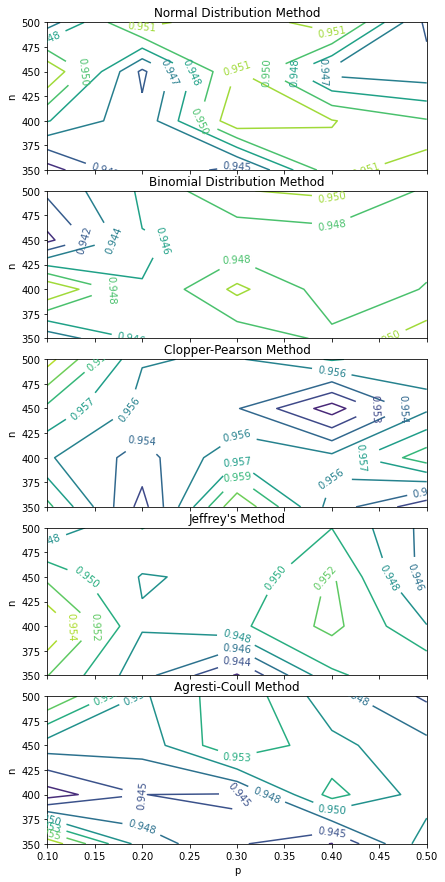

In [29]:
ci_dit = {"Normal Distribution Method": rs0,
          "Binomial Distribution Method": rs1,
          "Clopper-Pearson Method": rs2,
          "Jeffrey's Method": rs3,
          "Agresti-Coull Method": rs4}

fig1, ax1 = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(6,12))
fig1.tight_layout()
X, Y = np.meshgrid(plist, nlist)
for [i,j] in enumerate(ci_dit):
    Z = np.array(list(ci_dit[j].values()))
    cs = ax1[i].contour(X, Y, Z)
    ax1[i].clabel(cs, inline=True, fontsize=10)
    ax1[i].set_title(j)
    ax1[i].set_ylabel('n')
    
ax1[4].set_xlabel('p')

## part b) Relative Efficiency

Text(0.5, 86.9999999999999, 'p')

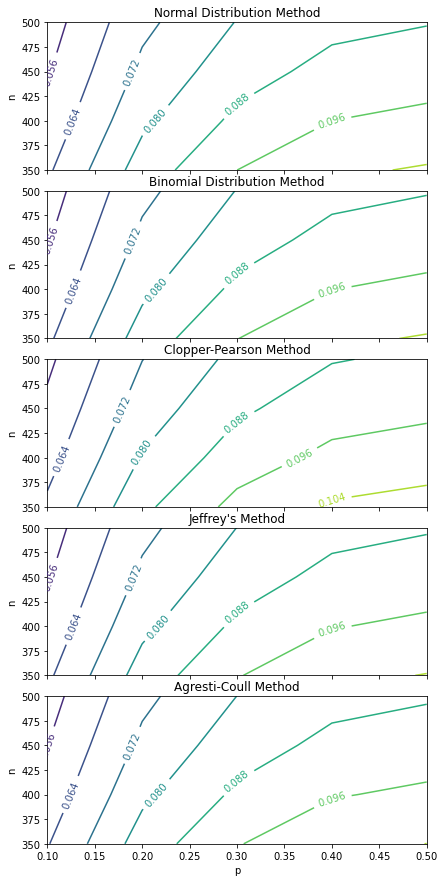

In [30]:
diff_wid0 = dict()
for k in wid0.keys():
    diff_wid0[k] = [np.mean(x) for x in wid0[k]]

diff_wid1 = dict()
for k in wid1.keys():
    diff_wid1[k] = [np.mean(x) for x in wid1[k]]

diff_wid2 = dict()
for k in wid2.keys():
    diff_wid2[k] = [np.mean(x) for x in wid2[k]]

diff_wid3 = dict()
for k in wid3.keys():
    diff_wid3[k] = [np.mean(x) for x in wid3[k]]

diff_wid4 = dict()
for k in wid4.keys():
    diff_wid4[k] = [np.mean(x) for x in wid4[k]]

wid_dit = {"Normal Distribution Method": diff_wid0,
          "Binomial Distribution Method": diff_wid1,
          "Clopper-Pearson Method": diff_wid2,
          "Jeffrey's Method": diff_wid3,
          "Agresti-Coull Method": diff_wid4}

fig2, ax2 = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(6,12))
fig2.tight_layout()

for [i,j] in enumerate(wid_dit):
    Z = np.array(list(wid_dit[j].values()))
    cs = ax2[i].contour(X, Y, Z)
    ax2[i].clabel(cs, inline=True, fontsize=10)
    ax2[i].set_title(j)
    ax2[i].set_ylabel('n')
    
ax2[4].set_xlabel('p')

Text(0.5, 86.9999999999999, 'p')

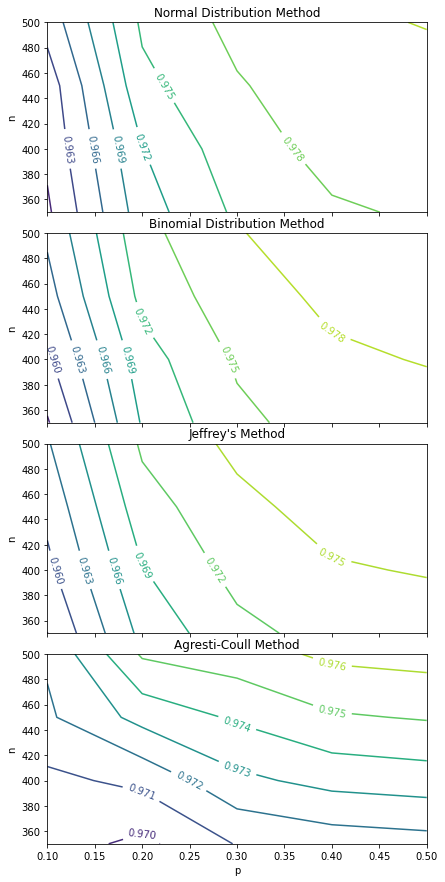

In [31]:
bdiff_wid0 = dict()
for k in diff_wid0.keys():
    bdiff_wid0[k] = np.array(diff_wid0[k])/np.array(diff_wid2[k])

bdiff_wid1 = dict()
for k in diff_wid1.keys():
    bdiff_wid1[k] = np.array(diff_wid1[k])/np.array(diff_wid2[k])

bdiff_wid3 = dict()
for k in diff_wid3.keys():
    bdiff_wid3[k] = np.array(diff_wid3[k])/np.array(diff_wid2[k])

bdiff_wid4 = dict()
for k in diff_wid4.keys():
    bdiff_wid4[k] = np.array(diff_wid4[k])/np.array(diff_wid2[k])
    
wid_re = {"Normal Distribution Method": bdiff_wid0,
          "Binomial Distribution Method": bdiff_wid1,
          "Jeffrey's Method": bdiff_wid3,
          "Agresti-Coull Method": bdiff_wid4}

fig3, ax3 = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(6,12))
fig3.tight_layout()

for [i,j] in enumerate(wid_re):
    Z = np.array(list(wid_re[j].values()))
    cs = ax3[i].contour(X, Y, Z)
    ax3[i].clabel(cs, inline=True, fontsize=10)
    ax3[i].set_title(j)
    ax3[i].set_ylabel('n')
    
ax3[3].set_xlabel('p')